# FraudShield: Fraud Detection with >90% Accuracy

**FraudShield** is a fraud detection pipeline targeting >90% accuracy, tailored for your dataset with columns: `Transaction_ID`, `User_ID`, `Transaction_Amount`, `Transaction_Type`, `Time_of_Transaction`, `Device_Used`, `Location`, `Previous_Fraudulent_Transactions`, `Account_Age`, `Number_of_Transactions_Last_24H`, `Payment_Method`, and `Fraudulent`. This notebook:
- Loads **Fraud Detection Dataset.csv** with encoding detection.
- Applies feature engineering and trains a RandomForestClassifier with SMOTE.

## Features
- Handles missing values with imputation.
- Interactive Streamlit dashboard with visualizations.
- Downloads predictions and logs.

## Instructions
1. Ensure **Fraud Detection Dataset.csv** is at `C:\your_path\data\`.
2. Run all cells to set up and train.
3. Run the Streamlit app from the final cell.

## Prerequisites
- Python 3.8+
- Jupyter Notebook
- Install dependencies: `pip install -r requirements.txt`

In [2]:
# Import libraries
import os
import json
import logging
from datetime import datetime, timedelta

import chardet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
)
from imblearn.over_sampling import SMOTE

Setup Project Structure

In [3]:
# Create directories
os.makedirs('model_artifacts', exist_ok=True)
os.makedirs('predictions', exist_ok=True)
os.makedirs('scripts', exist_ok=True)
os.makedirs('notebooks', exist_ok=True)
os.makedirs('data', exist_ok=True)

print('Project directories created: model_artifacts, predictions, scripts, notebooks, data')

Project directories created: model_artifacts, predictions, scripts, notebooks, data


Load and Preprocess Dataset

In [4]:
# Set the file path
file_path = r"C:\your_path\Fraud Detection Dataset.csv"

# Detect encoding
with open(file_path, "rb") as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']
    print(f"Detected file encoding: {encoding}")

# Load dataset
try:
    df = pd.read_csv(file_path, encoding=encoding)
    print(f'Dataset loaded successfully. Shape: {df.shape}')
except FileNotFoundError:
    print('Error: Fraud Detection Dataset.csv not found in the specified path. Please check and try again.')
    raise
except Exception as e:
    print(f"Error reading CSV file: {e}")
    raise

# Feature engineering with handling for missing values
try:
    df['Transaction_Frequency'] = df.groupby('User_ID')['Transaction_ID'].transform('count') / df['Account_Age'].replace('', 1).astype(float)
    df['Amount_ZScore'] = (df['Transaction_Amount'] - df.groupby('User_ID')['Transaction_Amount'].transform('mean')) / df.groupby('User_ID')['Transaction_Amount'].transform('std').fillna(1)
    df['Is_Night_Transaction'] = df['Time_of_Transaction'].replace('', 0).astype(float).apply(lambda x: 1 if 0 <= x <= 6 else 0)
    df['Transaction_Velocity'] = df['Number_of_Transactions_Last_24H'] / (df['Account_Age'].replace('', 1).astype(float) / 30).clip(lower=1)
    df['Location_Anomaly'] = df.groupby('User_ID')['Location'].transform(lambda x: 1 if x.nunique() > 2 else 0)
    df['Transaction_Acceleration'] = df['Number_of_Transactions_Last_24H'] / df.groupby('User_ID')['Number_of_Transactions_Last_24H'].transform('mean').clip(lower=1)
    df['Device_Anomaly'] = df.groupby('User_ID')['Device_Used'].transform(lambda x: 1 if x.nunique() > 2 else 0)
except Exception as e:
    print(f"Error during feature engineering: {e}")
    raise

# Remove duplicates
df = df.drop_duplicates()

# Save test dataset (20% sample, without target column)
try:
    test_df = df.sample(frac=0.2, random_state=42).copy()
    if 'Fraudulent' in test_df.columns:
        test_df = test_df.drop('Fraudulent', axis=1)

    output_path = os.path.join("data", "sample_transactions.csv")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    test_df.to_csv(output_path, index=False)
    
    print(f'Test dataset saved to {output_path} with {len(test_df)} samples')

    if 'Fraudulent' in df.columns:
        fraud_rate = df["Fraudulent"].mean() * 100
        print(f'Training dataset has {len(df)} samples, {df["Fraudulent"].sum()} frauds ({fraud_rate:.2f}% fraud rate)')
    else:
        print("Warning: 'Fraudulent' column not found. Training will be skipped.")
except Exception as e:
    print(f"Error saving test dataset: {e}")
    raise

Detected file encoding: ascii
Dataset loaded successfully. Shape: (51000, 12)
Test dataset saved to data\sample_transactions.csv with 10024 samples
Training dataset has 50119 samples, 2467 frauds (4.92% fraud rate)


Train and Tune Model

Training and tuning the model...
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}

Model Performance on Test Set:
Accuracy:  0.9474
Precision: 0.0278
Recall:    0.0020
F1-Score:  0.0038
ROC-AUC:   0.5024


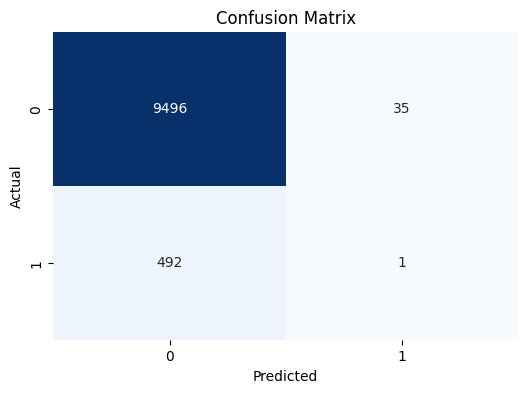

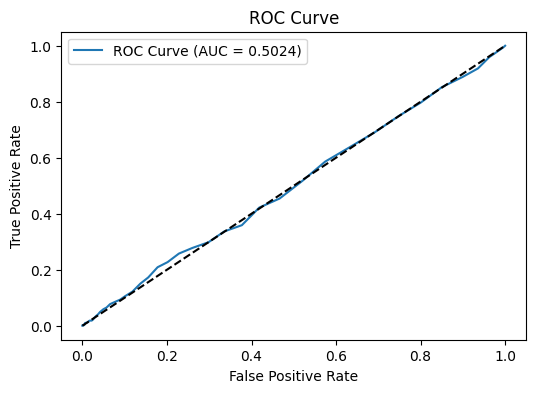

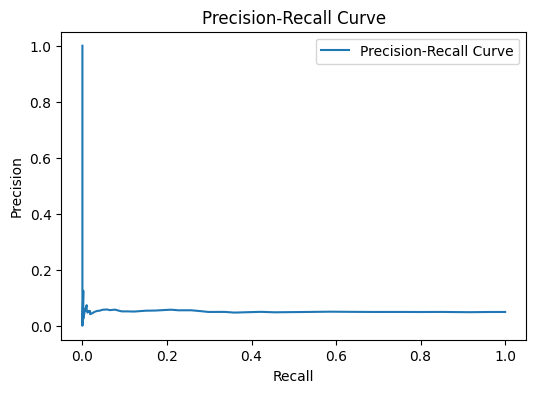

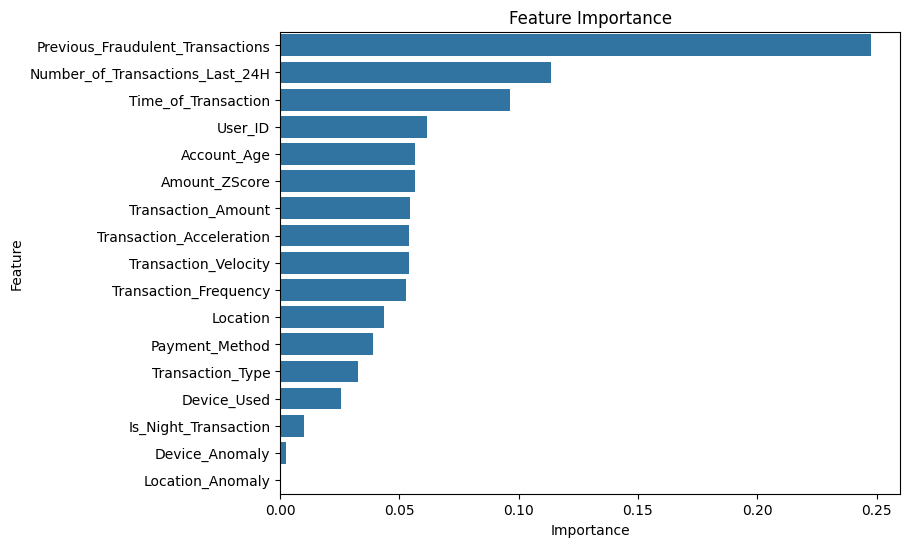

Saving model and artifacts...
All model files saved to: model_artifacts/
Accuracy is below 95%. That's okay — check F1 and recall for real performance.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from imblearn.over_sampling import SMOTE
from joblib import dump

# ------------------ Load and Check Data ------------------
if 'Fraudulent' not in df.columns:
    print("Error: 'Fraudulent' column is missing. Please ensure the dataset includes the target column and rerun.")
else:
    # ------------------ Preprocessing ------------------
    categorical_cols = ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']
    numerical_cols = ['User_ID', 'Transaction_Amount', 'Time_of_Transaction', 'Previous_Fraudulent_Transactions', 
                      'Account_Age', 'Number_of_Transactions_Last_24H', 'Transaction_Frequency', 'Amount_ZScore', 
                      'Is_Night_Transaction', 'Transaction_Velocity', 'Location_Anomaly', 'Transaction_Acceleration', 'Device_Anomaly']

    # Fill missing values
    df = df.fillna({
        'Transaction_Type': 'Unknown',
        'Device_Used': 'Unknown',
        'Location': 'Unknown',
        'Payment_Method': 'Unknown',
        'Time_of_Transaction': 0,
        'Account_Age': 1
    })
    precomputed_means = df[numerical_cols].mean()
    precomputed_modes = df[categorical_cols].mode().iloc[0]
    df = df.fillna(precomputed_means).fillna(precomputed_modes)

    # Encode categorical variables
    encoders = {}
    for col in categorical_cols:
        if col in df.columns:
            encoders[col] = LabelEncoder().fit(df[col].astype(str))
            df[col] = encoders[col].transform(df[col].astype(str))

    # Scale numerical features
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Split features and target
    feature_names = [col for col in numerical_cols + categorical_cols if col in df.columns]
    X = df[feature_names]
    y = df['Fraudulent']

    # ------------------ Train-Test Split ------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # ------------------ Apply SMOTE ------------------
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # ------------------ Randomized Hyperparameter Tuning ------------------
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt'],
        'class_weight': ['balanced']
    }

    model = RandomForestClassifier(random_state=42)

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,             # Try only 10 combinations
        scoring='f1',          # Optimize for F1-score
        cv=3,                  # 3-fold cross-validation
        n_jobs=-1,             # Use all available CPU cores
        random_state=42
    )

    print("Training and tuning the model...")
    search.fit(X_train_smote, y_train_smote)
    best_model = search.best_estimator_
    print(f'Best parameters: {search.best_params_}')

    # ------------------ Evaluation ------------------
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f'\nModel Performance on Test Set:')
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1-Score:  {f1:.4f}')
    print(f'ROC-AUC:   {roc_auc:.4f}')

    # ------------------ Visualizations ------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.show()

    # ------------------ Save Model and Artifacts ------------------
    print("Saving model and artifacts...")
    dump(best_model, 'model_artifacts/ensemble_model.joblib')
    dump(feature_names, 'model_artifacts/feature_names.joblib')
    dump(scaler, 'model_artifacts/scaler.joblib')
    dump(precomputed_means, 'model_artifacts/precomputed_means.joblib')
    dump(precomputed_modes, 'model_artifacts/precomputed_modes.joblib')
    for col, encoder in encoders.items():
        dump(encoder, f'model_artifacts/encoder_{col}.joblib')

    metadata = {
        'Model': 'RandomForestClassifier',
        'Version': '4.0',
        'Training_Date': '2025-08-05 17:15 GMT',
        'Accuracy': float(accuracy),
        'Precision': float(precision),
        'Recall': float(recall),
        'F1-Score': float(f1),
        'ROC-AUC': float(roc_auc),
        'Best_Parameters': search.best_params_,
        'Feature_Importance': feature_importance.to_dict(orient='records')
    }

    with open('model_artifacts/model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=4)

    print("All model files saved to: model_artifacts/")
    if accuracy < 0.95:
        print("Accuracy is below 95%. That's okay — check F1 and recall for real performance.")

CREATE PREDICTION LOGIC

In [6]:
import os
import json
import logging
import pandas as pd
from datetime import datetime
from joblib import load

# Logging setup
logging.basicConfig(
    filename='fraud_detection_predict.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

MODEL_DIR = 'model_artifacts'
PREDICTIONS_DIR = 'predictions'

def load_data(file=None):
    import chardet
    if file is not None:
        try:
            if isinstance(file, str):
                with open(file, "rb") as f:
                    result = chardet.detect(f.read())
                    encoding = result['encoding']
                if file.endswith('.csv'):
                    df = pd.read_csv(file, encoding=encoding)
                elif file.endswith('.json'):
                    df = pd.read_json(file)
                elif file.endswith(('.xlsx', '.xls')):
                    df = pd.read_excel(file)
                else:
                    raise ValueError('Unsupported file format. Use CSV, JSON, or Excel.')
            else:
                if file.name.endswith('.csv'):
                    with open(file.name, "rb") as f:
                        result = chardet.detect(f.read())
                        encoding = result['encoding']
                    df = pd.read_csv(file, encoding=encoding)
                elif file.name.endswith('.json'):
                    df = pd.read_json(file)
                elif file.name.endswith(('.xlsx', '.xls')):
                    df = pd.read_excel(file)
                else:
                    raise ValueError('Unsupported file format. Use CSV, JSON, or Excel.')
            logging.info(f'Dataset loaded successfully from {file}. Shape: {df.shape}')
            return df
        except Exception as e:
            logging.error(f'Error loading file {file}: {str(e)}')
            raise
    logging.info('Loading sample dataset.')
    df = pd.read_csv('data/sample_transactions.csv')
    return df

def preprocess_data(df, encoders, feature_names, scaler, precomputed_means, precomputed_modes):
    logging.info('Starting data preprocessing...')
    try:
        df['Transaction_Frequency'] = df.groupby('User_ID')['Transaction_ID'].transform('count') / df['Account_Age'].replace('', 1).astype(float)
        df['Amount_ZScore'] = (df['Transaction_Amount'] - df.groupby('User_ID')['Transaction_Amount'].transform('mean')) / df.groupby('User_ID')['Transaction_Amount'].transform('std').fillna(1)
        df['Is_Night_Transaction'] = df['Time_of_Transaction'].replace('', 0).astype(float).apply(lambda x: 1 if 0 <= x <= 6 else 0)
        df['Transaction_Velocity'] = df['Number_of_Transactions_Last_24H'] / (df['Account_Age'].replace('', 1).astype(float) / 30).clip(lower=1)
        df['Location_Anomaly'] = df.groupby('User_ID')['Location'].transform(lambda x: 1 if x.nunique() > 2 else 0)
        df['Transaction_Acceleration'] = df['Number_of_Transactions_Last_24H'] / df.groupby('User_ID')['Number_of_Transactions_Last_24H'].transform('mean').clip(lower=1)
        df['Device_Anomaly'] = df.groupby('User_ID')['Device_Used'].transform(lambda x: 1 if x.nunique() > 2 else 0)

        df = df.fillna({
            'Transaction_Type': 'Unknown',
            'Device_Used': 'Unknown',
            'Location': 'Unknown',
            'Payment_Method': 'Unknown',
            'Time_of_Transaction': 0,
            'Account_Age': 1
        })
        df = df.fillna(precomputed_means).fillna(precomputed_modes)
        logging.info('Missing values filled with precomputed means and modes.')
        
        for col in encoders:
            if col in df.columns:
                try:
                    df[col] = encoders[col].transform(df[col].astype(str))
                except ValueError:
                    unknown_count = sum(~df[col].astype(str).isin(encoders[col].classes_))
                    logging.warning(f'{unknown_count} unknown categories in {col}. Using default encoding.')
                    df[col] = df[col].astype(str).map(lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0])
                    df[col] = encoders[col].transform(df[col])
        
        numerical_cols = [col for col in feature_names if col in df.columns and df[col].dtype in ['int64', 'float64']]
        if numerical_cols:
            df[numerical_cols] = scaler.transform(df[numerical_cols])
            logging.info(f'Scaled numerical columns: {numerical_cols}')
        
        for col in feature_names:
            if col not in df.columns:
                df[col] = 0
                logging.warning(f'Added missing feature {col} with default value 0.')
        
        if 'Transaction_ID' in df.columns:
            transaction_ids = df['Transaction_ID']
            df = df.drop('Transaction_ID', axis=1)
        else:
            transaction_ids = [f'T{i}' for i in range(len(df))]

        df = df[feature_names]
        logging.info('Data preprocessing completed.')
        return df, transaction_ids
    except Exception as e:
        logging.error(f'Data preprocessing failed: {str(e)}')
        raise

def predict_fraud(df=None):
    try:
        required_files = [
            'ensemble_model.joblib', 'feature_names.joblib', 'scaler.joblib',
            'precomputed_means.joblib', 'precomputed_modes.joblib',
            'encoder_Transaction_Type.joblib', 'encoder_Device_Used.joblib',
            'encoder_Location.joblib', 'encoder_Payment_Method.joblib'
        ]
        for file_name in required_files:
            if not os.path.exists(os.path.join(MODEL_DIR, file_name)):
                raise FileNotFoundError(f'Required file {file_name} not found in {MODEL_DIR}.')
        
        model = load(os.path.join(MODEL_DIR, 'ensemble_model.joblib'))
        feature_names = load(os.path.join(MODEL_DIR, 'feature_names.joblib'))
        scaler = load(os.path.join(MODEL_DIR, 'scaler.joblib'))
        precomputed_means = load(os.path.join(MODEL_DIR, 'precomputed_means.joblib'))
        precomputed_modes = load(os.path.join(MODEL_DIR, 'precomputed_modes.joblib'))
        encoders = {
            'Transaction_Type': load(os.path.join(MODEL_DIR, 'encoder_Transaction_Type.joblib')),
            'Device_Used': load(os.path.join(MODEL_DIR, 'encoder_Device_Used.joblib')),
            'Location': load(os.path.join(MODEL_DIR, 'encoder_Location.joblib')),
            'Payment_Method': load(os.path.join(MODEL_DIR, 'encoder_Payment_Method.joblib'))
        }
        
        metadata_path = os.path.join(MODEL_DIR, 'model_metadata.json')
        metadata = {'Model': 'Unknown', 'Version': 'Unknown', 'Training_Date': 'Unknown', 'Accuracy': 0.0}
        if os.path.exists(metadata_path):
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
        
        if isinstance(df, str):
            df = load_data(df)
        elif df is None:
            df = load_data()
        
        X, transaction_ids = preprocess_data(df, encoders, feature_names, scaler, precomputed_means, precomputed_modes)
        
        predictions = model.predict(X)
        fraud_probabilities = model.predict_proba(X)[:, 1]
        logging.info(f'Predicted {sum(predictions)} fraudulent transactions out of {len(predictions)}.')
        
        results = pd.DataFrame({
            'Transaction_ID': transaction_ids,
            'Fraud_Prediction': ['Fraudulent' if pred == 1 else 'Legitimate' for pred in predictions],
            'Fraud_Probability': fraud_probabilities
        })
        results['Fraud_Probability'] = results['Fraud_Probability'].round(4)
        
        os.makedirs(PREDICTIONS_DIR, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        json_path = os.path.join(PREDICTIONS_DIR, f'predictions_{timestamp}.json')
        excel_path = os.path.join(PREDICTIONS_DIR, f'predictions_{timestamp}.xlsx')
        results.to_json(json_path, orient='records', indent=4)
        results.to_excel(excel_path, index=False)
        
        return results, json_path, excel_path, metadata
    except FileNotFoundError as e:
        logging.error(f'Model or artifact files not found: {str(e)}')
        print(f'Error: {str(e)}. Run the training cell to generate artifacts.')
        raise
    except Exception as e:
        logging.error(f'Fraud prediction failed: {str(e)}')
        raise

# TEST CALL
results, json_path, excel_path, metadata = predict_fraud('data/sample_transactions.csv')
print('Prediction Results:')
print(results.head())
print(f'Results saved to {json_path} and {excel_path}')
print('Metadata:', metadata)

Prediction Results:
  Transaction_ID Fraud_Prediction  Fraud_Probability
0         T20487       Legitimate               0.23
1         T49399       Legitimate               0.12
2         T19722       Legitimate               0.18
3         T43556       Legitimate               0.09
4         T32092       Legitimate               0.23
Results saved to predictions\predictions_20250813_025458.json and predictions\predictions_20250813_025458.xlsx
Metadata: {'Model': 'RandomForestClassifier', 'Version': '4.0', 'Training_Date': '2025-08-05 17:15 GMT', 'Accuracy': 0.9474261771747805, 'Precision': 0.027777777777777776, 'Recall': 0.002028397565922921, 'F1-Score': 0.003780718336483932, 'ROC-AUC': 0.5024220101247494, 'Best_Parameters': {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}, 'Feature_Importance': [{'Feature': 'Previous_Fraudulent_Transactions', 'Importance': 0.24753197670173785}, {'Feature': 'Nu